In [1]:
from modules.tweet_data import read_raw_data
from modules.topics import TopicSeries, display_components

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import spacy
import pickle
import datetime as dt

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [4]:
#tweet_df = read_raw_data()
es = pd.read_csv('data/ES.csv')
es = es[es.Time == '15:00'][['Date','Time','Close']]
es.Date = pd.to_datetime(es.Date +' ' +'15:45')
es.drop('Time',axis=1,inplace=True)
es.set_index('Date', inplace=True)


In [5]:
date_range = es['2011-12-30':'2020-5-31'].index


In [4]:
ts=TopicSeries()
ts.fit(tweet_df, date_range)
ts.save('topics' + '-' + str(date_range[0].date()) + '-' + str(date_range[-1].date()) + '.p')
    

In [ ]:
batches = [date_range[-500:], 
           date_range[-1000:-499], 
           date_range[-1500:-999], 
           date_range[:-1499]]

for batch in batches:
    ts=TopicSeries()
    ts.fit(tweet_df, batch)
    ts.save('data/topics' + '-' + str(batch[0].date()) + '-' + str(batch[-1].date()) + '.p')
    

In [10]:
ts = pickle.load(open('data/topics-2011-12-30-2020-05-29.p','rb'))

In [5]:
classi = pd.read_csv('data/handle_class.csv')
tweet_df = pd.merge(tweet_df,classi[['class','handle','subclass']],on=['handle'], right_index=True)
# Need to resort by index as merge messes up with datetime indexing
tweet_df.sort_index(inplace=True)
tweet_df = tweet_df[tweet_df['class'] == 'fintwit']

In [5]:
tweet_df.head()

,tweet_id,handle,tweet,class,subclass
timestamp,,,,,
2006-09-22 09:02:46,33743,guan,"Hello, World!",fintwit,opinion
2006-09-22 09:21:33,33745,guan,Working on a cool new project at Steffen's house.,fintwit,opinion
2007-01-17 21:43:23,3175083,MarketWatch,Ex-Cendant chairman gets 12-year-plus prison s...,fintwit,news
2007-01-17 21:43:25,3175143,MarketWatch,Ex-Cendant chairman gets 12-year prison senten...,fintwit,news
2007-01-17 21:44:50,3175323,MarketWatch,Home builders' sentiment rises to highest leve...,fintwit,news


In [ ]:
ts=TopicSeries()
ts.fit(tweet_df, date_range)
ts.save('data/topics-fintwit' + '-' + str(date_range[0].date()) + '-' + str(date_range[-1].date()) + '.p')

In [3]:
top_display = 20
top_words = []
word_features =  ts.tfidf_dict['2018-10-19'].get_feature_names()
for topic_idx, topic in enumerate(ts.nmf_dict['2018-10-19'].components_):
    top_words_idx = topic.argsort()[::-1][:top_display]
    top_words.append([word_features[i] for i in top_words_idx])

In [4]:
ts.nmf_dict['2018-10-19'].reconstruction_err_

107.09420242775161

In [ ]:
Measures between topics and days:

Conclusion: cosine similarity between top words should work

Cross entropy could work for LDA if probabilities. Take top XX words from each topic, and calculate
cross entropy with next day. You need to concat the words and find the index for each word in each day

Are NMF vectors probabilities?

Topics  
NMF  
Calc:   
recon error  
topic coherence (intraday) if high average, probably less topics leading, if low, more topics  
between days distances  
Avg of max  If low, change in subjects  
num Of unique topics   If low, change in subjects

# Cosine Similarity

In [2]:
ts = pickle.load(open('data/topics-2011-12-30-2020-05-29.p','rb'))

In [3]:
dates = sorted(list(ts.nmf_dict.keys()))
date_dict = {date:i for i, date in enumerate(dates)}

In [4]:
top_words_list = []
top_args_list = []
top_proba_list = []
top_display = 20

for date in dates:
    print(date,end="\r")
    top_words = []
    top_args = []
    top_proba  = []
    word_features =  ts.tfidf_dict[date].get_feature_names()
    for topic_idx, topic in enumerate(ts.nmf_dict[date].components_):
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_proba.append(sorted(topic)[::-1][:top_display])
        top_words.append([word_features[i] for i in top_words_idx])
        top_args.append(top_words_idx)
    top_words_list.append(top_words)
    top_args_list.append(top_args)
    top_proba_list.append(top_proba)

2018-03-05


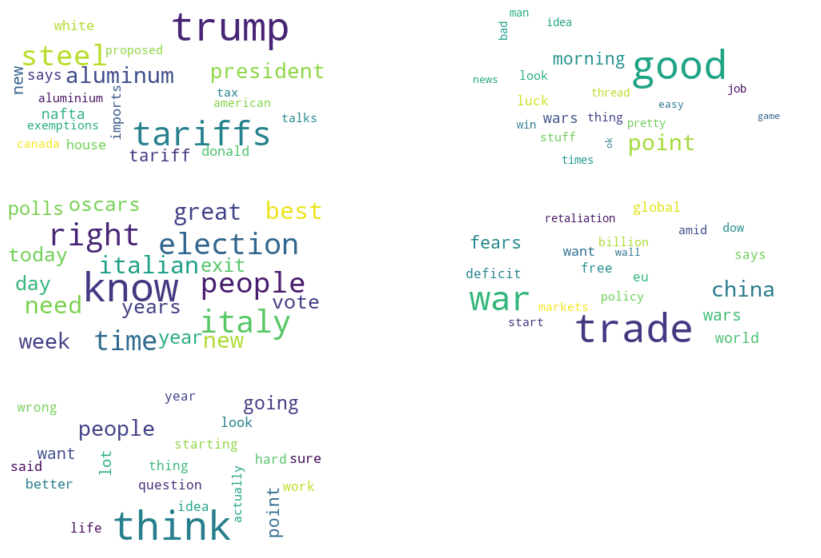

In [31]:
day = date_dict['2018-03-05']

def word_clouds(day):
    print(dates[day])
    wc = WordCloud(max_font_size=50, contour_width=3, background_color='white')

    fig, ax = plt.subplots(3,2,figsize=(15,10))
    ax = ax.ravel()
    for i in range(5):
        wordcloud = wc.generate_from_frequencies({q:t for t, q in zip(top_proba_list[day][i],top_words_list[day][i])})
        ax[i].imshow(wordcloud, interpolation="bilinear")
        ax[i].axis("off")
    ax[5].axis("off");

word_clouds(day)

In [6]:
nlp_mid = spacy.load('en_core_web_md')

concat_words = [[' '.join(top_words) for top_words in sub_top_list] for sub_top_list in top_words_list]
word_vectors = [[nlp_mid(topic_words).vector for topic_words in concat_word] for concat_word in concat_words]

topic_coherence = []
topic_coherence_diff = []
num_topics_change = []

n_topics = 5
den = (n_topics**2-n_topics)
for i in range(len(word_vectors)-1):
    cs = cosine_similarity(word_vectors[i] + word_vectors[i+1])
    # Topic coherence
    tc = (cs[n_topics:2*n_topics,n_topics:2*n_topics].sum() \
        - cs[n_topics:2*n_topics,n_topics:2*n_topics].diagonal().sum())/den
    topic_coherence.append(tc)
    # Topic coherence difference betweent day i and i+1
    tcd = cs[0:n_topics,n_topics:2*n_topics].max(axis=1).mean()
    topic_coherence_diff.append(tcd) 
    num_ts = len(np.unique(cs[0:n_topics,n_topics:2*n_topics].argmax(axis=1)))
    num_topics_change.append(num_ts)


In [7]:
nmf_features = pd.DataFrame(index = dates[1:])
nmf_features['topic_coherence'] = topic_coherence
nmf_features['topic_coherence_diff'] = topic_coherence_diff
nmf_features['num_topics_change'] = num_topics_change

nmf_features.head()

,topic_coherence,topic_coherence_diff,num_topics_change
2012-01-04,0.744901,0.898953,2
2012-01-05,0.644985,0.845906,2
2012-01-06,0.729873,0.811649,3
2012-01-09,0.670430,0.847776,3
2012-01-10,0.686796,0.872777,2


# Entropy

2020-03-20


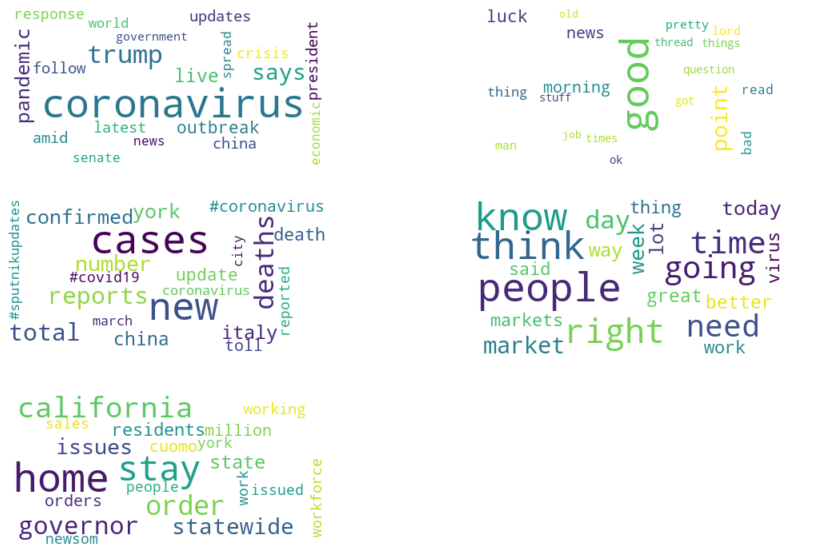

In [22]:
day = date_dict['2020-03-20']

word_clouds(day)

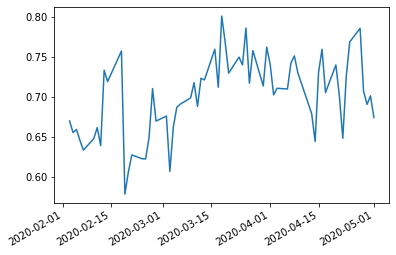

In [26]:
#corona
nmf_features.index = pd.to_datetime(nmf_features.index)
nmf_features['2020-02-01':'2020-05-01'].topic_coherence.plot();

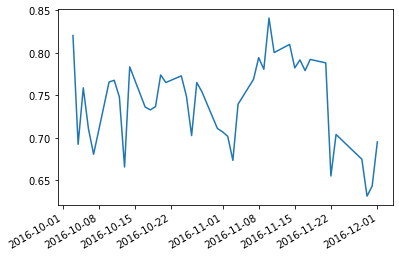

In [27]:
#election
nmf_features['2016-10-01':'2016-12-01'].topic_coherence.plot();

In [56]:
# 5x20, each of these is a probability, how to use entropy to measure?
ts.nmf_dict[date].components_[:,top_args[0]]

array([[9.41691146e-01, 7.29245633e-01, 7.22425772e-01, 5.82367276e-01,
        5.40866538e-01, 4.67197163e-01, 4.54668552e-01, 4.54618090e-01,
        4.44260666e-01, 4.39739661e-01, 4.35161474e-01, 3.99852181e-01,
        3.91100571e-01, 3.79672436e-01, 3.39545932e-01, 3.29667052e-01,
        3.24333526e-01, 3.14946909e-01, 2.97518570e-01, 2.90099951e-01],
       [8.33436601e-03, 6.34034190e-04, 0.00000000e+00, 3.16908490e-02,
        3.24202594e-03, 0.00000000e+00, 0.00000000e+00, 6.08975172e-02,
        0.00000000e+00, 0.00000000e+00, 6.35425280e-02, 1.98853321e-02,
        0.00000000e+00, 0.00000000e+00, 4.76677619e-02, 1.03352506e-02,
        1.34543845e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.46384721e-02, 1.78969527e-02, 4.06346078e-02,
        0.00000000e+00, 0.00000000e+00, 2.94953183e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 8.17845204e-02, 0.0000

In [58]:
from scipy.stats import entropy

In [104]:
# Need to match word probabilities/indices between days
aaa = ts.nmf_dict[date].components_[0]/ts.nmf_dict[date].components_[0].sum()
bbb = ts.nmf_dict[date].components_[1]/ts.nmf_dict[date].components_[1].sum()

In [105]:
aaa[aaa>0].dot(np.log(bbb[bbb>0]))

ValueError: shapes (17844,) and (5872,) not aligned: 17844 (dim 0) != 5872 (dim 0)

In [119]:
A = ts.nmf_dict[date].components_
A[A==0] = 1e-15
A

array([[1.03869419e-02, 3.19901698e-02, 5.92124026e-04, ...,
        1.72551758e-04, 3.35822443e-04, 1.72551758e-04],
       [1.00000000e-15, 1.00000000e-15, 1.00000000e-15, ...,
        1.00000000e-15, 1.00000000e-15, 1.00000000e-15],
       [7.67170612e-03, 1.00000000e-15, 1.00000000e-15, ...,
        1.00000000e-15, 1.00000000e-15, 1.00000000e-15],
       [1.02803427e-03, 2.37004812e-02, 1.00000000e-15, ...,
        5.28806240e-05, 1.00000000e-15, 5.28806240e-05],
       [1.00000000e-15, 1.00000000e-15, 1.40111904e-04, ...,
        1.00000000e-15, 1.00000000e-15, 1.00000000e-15]])

In [123]:
entropy(ts.nmf_dict[date].components_[0])

8.375995828555052

In [125]:
entropy(ts.nmf_dict[date].components_[0],qk=(ts.nmf_dict[date].components_[1]))

17.086682064097044

In [132]:
[[entropy(ts.nmf_dict[dates[0]].components_[i],qk=(ts.nmf_dict[dates[0]].components_[j])) for i in range(5)]for j in range(5)]

[[0.0, inf, inf, inf, inf],
 [inf, 0.0, inf, inf, inf],
 [inf, inf, 0.0, inf, inf],
 [inf, inf, inf, 0.0, inf],
 [inf, inf, inf, inf, 0.0]]

In [ ]:
[[entropy(ts.nmf_dict[date].components_[i],qk=(ts.nmf_dict[date].components_[j])) for i in range(5)]for j in range(5)]

In [113]:
entropy(ts.nmf_dict[date].components_[0],qk=(ts.nmf_dict[date].components_[2]+1e-15))

18.70549419755346

In [114]:
entropy(ts.nmf_dict[date].components_[0],qk=(ts.nmf_dict[date].components_[3]+1e-15))

15.274803048704879

In [115]:
entropy(ts.nmf_dict[date].components_[0],qk=(ts.nmf_dict[date].components_[4]+1e-15))

19.802016016333614

In [88]:
ts.nmf_dict[date].components_[0].dot(np.log(ts.nmf_dict[date].components_[0]))

/Users/lalopey/opt/anaconda3/envs/tweet-sentiment/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


nan

In [98]:
ts.nmf_dict[date].components_[1].sum()

14.961622403118877

In [89]:
ts.nmf_dict[date].components_[0][ts.nmf_dict[date].components_[0] > 0.01].dot(np.log(ts.nmf_dict[date].components_[0][ts.nmf_dict[date].components_[0] > 0.01]))

-228.81431983349367

In [80]:
ts.nmf_dict[date].components_[0] * np.log(ts.nmf_dict[date].components_[0])

/Users/lalopey/opt/anaconda3/envs/tweet-sentiment/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/lalopey/opt/anaconda3/envs/tweet-sentiment/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


array([-0.0474393 , -0.11012061, -0.00440054, ..., -0.00149513,
       -0.00268622, -0.00149513])

In [134]:
q = [1]
if q:
    print(1)

1
